# 5.1 합성곱 신경망 소개

In [2]:
# 간단한 컨브넷

from keras import layers
from keras import models

model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),    # 3 x 3 크기를 사용, 32개 필터
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu')
])

In [3]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 13, 13, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 11, 11, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 5, 5, 64)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 3, 3, 64)          36928     
                                                                 
Total params: 55,744
Trainable params: 55,744
Non-traina

In [4]:
# 컨브넷 위에 분류기 추가
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(10, activation='softmax'))

In [5]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 13, 13, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 11, 11, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 5, 5, 64)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 3, 3, 64)          36928     
                                                                 
 flatten (Flatten)           (None, 576)               0

In [6]:
from keras.datasets import mnist
from keras.utils import to_categorical

(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

In [8]:
train_images = train_images.reshape((60000, 28, 28, 1))
train_images = train_images.astype('float32') / 255

test_images = test_images.reshape((10000, 28, 28, 1))
test_images = test_images.astype('float32') / 255

train_labels = to_categorical(train_labels)
test_labels = to_categorical(test_labels)

model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

model.fit(train_images, train_labels, epochs=5, batch_size=64)

Epoch 1/5
938/938 [==============================] - 22s 22ms/step - loss: 0.1688 - accuracy: 0.9469
Epoch 2/5
938/938 [==============================] - 22s 23ms/step - loss: 0.0471 - accuracy: 0.9855
Epoch 3/5
938/938 [==============================] - 25s 27ms/step - loss: 0.0336 - accuracy: 0.9895
Epoch 4/5
938/938 [==============================] - 24s 25ms/step - loss: 0.0250 - accuracy: 0.9923
Epoch 5/5
938/938 [==============================] - 21s 22ms/step - loss: 0.0194 - accuracy: 0.9938


In [9]:
test_loss, test_acc = model.evaluate(test_images, test_labels)
test_acc

313/313 [==============================] - 1s 4ms/step - loss: 0.0399 - accuracy: 0.9895


0.9894999861717224

## 5.1.1 합성곱 연산

- 학습된 패턴은 평행 이동 불변성을 가짐: 이미지의 오른쪽 아래 모서리에서 어떤 패턴을 학습했다면 다른 곳에서도 이 패턴을 인식할 수 있음
- 패턴의 공간적 계층구조를 학습

`Conv2D(output_depth, (window_height, window_width))`

앞선 예시에서 28 x 28 크기의 입력이 3 x 3의 필터를 만나 26 x 26 크기로 반환됨(가로3 높이3이므로 각각 (3-1), (3-1)개만큼 줄어들음)

만약 입력과 동일한 높이와 너비를 가진 출력을 얻고싶다면 패딩(입력 가장자리에 적절한 개수의 열과 행 추가)을 활용하면 됨

Conv2D 층에서 패딩은 padding='valid'(패딩 X) or 'same'(입력과 동일한 높이와 너비를 가진 출력을 만들기 위해 패딩)이 존재

스트라이드: 상하좌우로 이동할 칸의 개수. 기본값은 1

보통 다운샘플링하기 위해 사용하지만 실전에서는 맥스풀링 연산을 더 많이 사용

## 5.1.2 Max Pooling 연산

앞선 예제에서 첫번째 MaxPooling2D 층 이전에는 26x26이였는데 이후 13x13으로 줄어들음

강제적으로 특성맵을 다운샘플링 하는 것이 최대 풀링의 역할

MaxPooling은 보통 2 x 2의 윈도우와 스트라이드 2를 사용하여 특성맵을 절반크기로 다운샘플링

Conv2D 층만 여러겹을 겹친다면 너무 많은 파라미터를 가지기 때문에 MaxPooling 등을 통해 다운샘플링 할 필요가 있음

윈도우의 각 칸의 최댓값을 가져가는 MaxPooling 대신에 평균으로 반환하는 Average Pooling을 사용할 수도 있음. 하지만 최대풀링이 보통 더 잘 작동하는 편이기 때문에, 이를 사용

# 5.2 소규모 데이터셋에서 밑바닥부터 컨브넷 훈련하기

## 5.2.1 작은 데이터셋 문제에서 딥러닝의 타당성

보통 딥러닝은 데이터가 풍부할 때만 작동한다는 말이 있지만, 모델이 작고 규제가 잘 되어있으며 간단한 작업이라면 수백 개의 샘플로도 충분할 수 있다

## 5.2.2 데이터 내려받기

In [13]:
import os, shutil

original_dataset_dir = 'C:/Users/ytnal/python/케라스창시자/datasets/cats_and_dogs/train'

base_dir = 'C:/Users/ytnal/python/케라스창시자/datasets/cats_and_dogs_small'

In [16]:
# 훈련, 검증, 테스트 분할을 위한 디렉터리
train_dir = os.path.join(base_dir, 'train')
os.mkdir(train_dir)
validation_dir = os.path.join(base_dir, 'validation')
os.mkdir(validation_dir)
test_dir = os.path.join(base_dir, 'test')
os.mkdir(test_dir)

# 훈련용 고양이 사진 디렉터리
train_cats_dir = os.path.join(train_dir, 'cats')
os.mkdir(train_cats_dir)

# 훈련용 강아지 사진 디렉터리
train_dogs_dir = os.path.join(train_dir, 'dogs')
os.mkdir(train_dogs_dir)

# 검증용 고양이 사진 디렉터리
validation_cats_dir = os.path.join(validation_dir, 'cats')
os.mkdir(validation_cats_dir)

# 검증용 강아지 사진 디렉터리
validation_dogs_dir = os.path.join(validation_dir, 'dogs')
os.mkdir(validation_dogs_dir)

# 테스트용 고양이 사진 디렉터리
test_cats_dir = os.path.join(test_dir, 'cats')
os.mkdir(test_cats_dir)

# 테스트용 강아지 사진 디렉터리
test_dogs_dir = os.path.join(test_dir, 'dogs')
os.mkdir(test_dogs_dir)

# 처음 1,000개의 고양이 이미지를 train_cats_dir에 복사합니다
fnames = ['cat.{}.jpg'.format(i) for i in range(1000)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(train_cats_dir, fname)
    shutil.copyfile(src, dst)

# 다음 500개 고양이 이미지를 validation_cats_dir에 복사합니다
fnames = ['cat.{}.jpg'.format(i) for i in range(1000, 1500)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(validation_cats_dir, fname)
    shutil.copyfile(src, dst)
    
# 다음 500개 고양이 이미지를 test_cats_dir에 복사합니다
fnames = ['cat.{}.jpg'.format(i) for i in range(1500, 2000)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(test_cats_dir, fname)
    shutil.copyfile(src, dst)
    
# 처음 1,000개의 강아지 이미지를 train_dogs_dir에 복사합니다
fnames = ['dog.{}.jpg'.format(i) for i in range(1000)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(train_dogs_dir, fname)
    shutil.copyfile(src, dst)
    
# 다음 500개 강아지 이미지를 validation_dogs_dir에 복사합니다
fnames = ['dog.{}.jpg'.format(i) for i in range(1000, 1500)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(validation_dogs_dir, fname)
    shutil.copyfile(src, dst)
    
# 다음 500개 강아지 이미지를 test_dogs_dir에 복사합니다
fnames = ['dog.{}.jpg'.format(i) for i in range(1500, 2000)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(test_dogs_dir, fname)
    shutil.copyfile(src, dst)

## 5.2.3 네트워크 구성하기

In [20]:
from keras import layers
from keras import models

model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

In [21]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 74, 74, 32)       0         
 2D)                                                             
                                                                 
 conv2d_9 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 36, 36, 64)       0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 17, 17, 128)     

In [22]:
from keras import optimizers

model.compile(loss='binary_crossentropy', optimizer=optimizers.RMSprop(lr=1e-4), metrics=['acc'])

C:\Users\ytnal\Anaconda3\lib\site-packages\keras\optimizers\optimizer_v2\rmsprop.py:135: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


## 5.2.4 데이터 전처리

In [23]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=1/255)
test_datagen = ImageDataGenerator(rescale=1/255)

train_generator = train_datagen.flow_from_directory(train_dir,
                                                   target_size=(150, 150), batch_size=20, class_mode='binary')
validation_generator = test_datagen.flow_from_directory(validation_dir,
                                                       target_size=(150, 150), batch_size=20, class_mode='binary') 

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [25]:
for data_batch, labels_batch in train_generator:
    print('배치 데이터 크기:', data_batch.shape)
    print('배치 레이블 크기:', labels_batch.shape)
    break

배치 데이터 크기: (20, 150, 150, 3)
배치 레이블 크기: (20,)


In [26]:
history = model.fit_generator(train_generator, steps_per_epoch=100, epochs=30, validation_data=validation_generator,
                             validation_steps=50)

Epoch 1/30


C:\Users\ytnal\AppData\Local\Temp\ipykernel_3720\553954090.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_generator, steps_per_epoch=100, epochs=30, validation_data=validation_generator,


100/100 [==============================] - 46s 454ms/step - loss: 0.6894 - acc: 0.5390 - val_loss: 0.6755 - val_acc: 0.5830
Epoch 2/30
100/100 [==============================] - 39s 391ms/step - loss: 0.6611 - acc: 0.6020 - val_loss: 0.6556 - val_acc: 0.6050
Epoch 3/30
100/100 [==============================] - 42s 421ms/step - loss: 0.6270 - acc: 0.6425 - val_loss: 0.6247 - val_acc: 0.6540
Epoch 4/30
100/100 [==============================] - 44s 436ms/step - loss: 0.5852 - acc: 0.6940 - val_loss: 0.6531 - val_acc: 0.6060
Epoch 5/30
100/100 [==============================] - 47s 467ms/step - loss: 0.5568 - acc: 0.7145 - val_loss: 0.5979 - val_acc: 0.6790
Epoch 6/30
100/100 [==============================] - 46s 458ms/step - loss: 0.5222 - acc: 0.7370 - val_loss: 0.5873 - val_acc: 0.6650
Epoch 7/30
100/100 [==============================] - 41s 413ms/step - loss: 0.5038 - acc: 0.7560 - val_loss: 0.5792 - val_acc: 0.6740
Epoch 8/30
100/100 [==============================] - 42s 421ms/st

In [28]:
model.save('cats_and_dogs_small_1.h5')

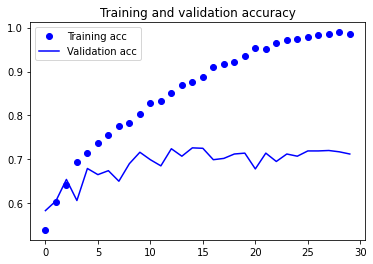

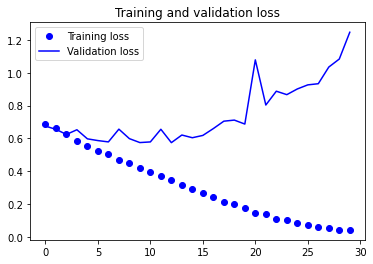

In [29]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

## 5.2.5 데이터 증식 사용하기

과대적합은 학습한 샘플이 너무 적어 새로운 데이터에 일반화할 수 있는 모델을 훈련시킬 수 없기 때문에 발생.

데이터 증식은 기존 훈련 샘플로부터 더 많은 훈련 데이터를 생성

In [36]:
datagen = ImageDataGenerator(
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

- rotation_range : 랜덤하게 사진을 회전시킬 각도 범위(0~180 사이)
- width_shift_range, height_shift_range : 사진을 수평과 수직으로 랜덤하게 평행이동시킬 범위
- shear_range : 랜덤하게 전단 변환을 적용할 각도 범위
- zoom_range : 랜덤하게 사진을 확대할 범위
- horizontal_flip : 랜덤하게 이미지를 수평으로 뒤집기
- fill_mode : 회전이나 가로/세로 이동으로 인해 새롭게 생성해야 할 픽셀을 채울 전략

In [39]:
# 드롭아웃을 포함한 새로운 컨브넷

model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu',
                        input_shape=(150, 150, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-4),
              metrics=['acc'])

In [40]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,)

# 검증 데이터는 증식되어서는 안 됩니다!
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        # 타깃 디렉터리
        train_dir,
        # 모든 이미지를 150 × 150 크기로 바꿉니다
        target_size=(150, 150),
        batch_size=32,
        # binary_crossentropy 손실을 사용하기 때문에 이진 레이블을 만들어야 합니다
        class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=32,
        class_mode='binary')

history = model.fit_generator(
      train_generator,
      steps_per_epoch=100,
      epochs=100,
      validation_data=validation_generator,
      validation_steps=50)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


C:\Users\ytnal\AppData\Local\Temp\ipykernel_3720\2559649682.py:28: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


Epoch 1/100
100/100 [==============================] - 45s 433ms/step - loss: 0.6918 - acc: 0.5295 - val_loss: 0.6878 - val_acc: 0.5000


In [35]:
model.save('cats_and_dogs_small_2.h5')

# 5.3 사전 훈련된 컨브넷 사용하기

## 5.3.1 특성 추출

사전에 학습된 네트워크의 표현을 사용하여 샘플에서 흥미로운 특성을 뽑아내는 것

In [16]:
from keras.applications import VGG16

conv_base = VGG16(weights='imagenet', include_top=False, input_shape=(150, 150, 3)) 
# include_top은 최상위 분류기(imagenet에서는 1000개의 클래스에 대응하는 분류기)를 포함할 지의 여부. 
# 여기선 강아지와 고양이 두 클래스만 분류할 것이므로 False

In [4]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 37, 37, 128)       0     

In [5]:
import os
import numpy as np
from keras.preprocessing.image import ImageDataGenerator

base_dir = 'C:/Users/ytnal/python/케라스창시자/datasets/cats_and_dogs_small'

train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

datagen = ImageDataGenerator(rescale=1./255)
batch_size = 20

def extract_features(directory, sample_count):
    features = np.zeros(shape=(sample_count, 4, 4, 512))
    labels = np.zeros(shape=(sample_count))
    generator = datagen.flow_from_directory(
        directory,
        target_size=(150, 150),
        batch_size=batch_size,
        class_mode='binary')
    i = 0
    for inputs_batch, labels_batch in generator:test)
        features_batch = conv_base.predict(inputs_batch)
        features[i * batch_size : (i + 1) * batch_size] = features_batch
        labels[i * batch_size : (i + 1) * batch_size] = labels_batch
        i += 1
        if i * batch_size >= sample_count:
            # 제너레이터는 루프 안에서 무한하게 데이터를 만들어내므로 모든 이미지를 한 번씩 처리하고 나면 중지합니다
            break
    return features, labels

train_features, train_labels = extract_features(train_dir, 2000)
validation_features, validation_labels = extract_features(validation_dir, 1000)
test_features, test_labels = extract_features(test_dir, 1000)

Found 2000 images belonging to 2 classes.
1/1 [==============================] - 2s 2s/step
Found 1000 images belonging to 2 classes.
1/1 [==============================] - 2s 2s/step
Found 1000 images belonging to 2 classes.
1/1 [==============================] - 2s 2s/step


1/1 [==============================] - 1s 1s/step


In [6]:
train_features = np.reshape(train_features, (2000, 4*4*512))
validation_features = np.reshape(validation_features, (1000, 4*4*512))
test_features = np.reshape(test_features, (1000, 4*4*512))

In [9]:
from keras import models
from keras import layers
from keras import optimizers

# 완전 연결 분류기 정의
model = models.Sequential([
    layers.Dense(256, activation='relu', input_dim=4*4*512),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer=optimizers.RMSprop(lr=2e-5), loss='binary_crossentropy', metrics=['acc'])

history = model.fit(train_features, train_labels, epochs=30, batch_size=20, validation_data=(validation_features, validation_labels))

Epoch 1/30


C:\Users\ytnal\Anaconda3\lib\site-packages\keras\optimizers\optimizer_v2\rmsprop.py:135: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


100/100 [==============================] - 3s 22ms/step - loss: 0.6248 - acc: 0.6465 - val_loss: 0.4533 - val_acc: 0.8430
Epoch 2/30
100/100 [==============================] - 2s 22ms/step - loss: 0.4345 - acc: 0.7980 - val_loss: 0.3674 - val_acc: 0.8590
Epoch 3/30
100/100 [==============================] - 2s 24ms/step - loss: 0.3633 - acc: 0.8400 - val_loss: 0.3250 - val_acc: 0.8800
Epoch 4/30
100/100 [==============================] - 2s 22ms/step - loss: 0.3160 - acc: 0.8750 - val_loss: 0.3025 - val_acc: 0.8860
Epoch 5/30
100/100 [==============================] - 2s 23ms/step - loss: 0.2862 - acc: 0.8865 - val_loss: 0.2852 - val_acc: 0.8880
Epoch 6/30
100/100 [==============================] - 2s 21ms/step - loss: 0.2644 - acc: 0.8910 - val_loss: 0.2725 - val_acc: 0.8930
Epoch 7/30
100/100 [==============================] - 2s 21ms/step - loss: 0.2439 - acc: 0.9010 - val_loss: 0.2638 - val_acc: 0.8940
Epoch 8/30
100/100 [==============================] - 2s 21ms/step - loss: 0.240

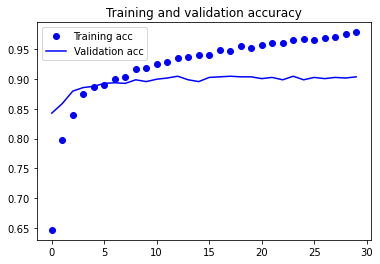

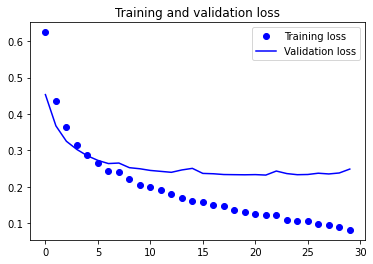

In [10]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

데이터 증식을 사용한 특성 추출

In [12]:
model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

In [13]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten_1 (Flatten)         (None, 8192)              0         
                                                                 
 dense_3 (Dense)             (None, 256)               2097408   
                                                                 
 dense_4 (Dense)             (None, 1)                 257       
                                                                 
Total params: 16,812,353
Trainable params: 16,812,353
Non-trainable params: 0
_________________________________________________________________


In [17]:
# 동결

conv_base.trainable = False

In [19]:
# 너무 오래걸려서 패스.

from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers

train_datagen = ImageDataGenerator(rescale=1/255, rotation_range=20, width_shift_range=0.1, height_shift_range = 0.1,
                                   shear_range=0.1, zoom_range=0.1, horizontal_flip=True, fill_mode='nearest')

test_datagen = ImageDataGenerator(rescale=1/255)

train_generator = train_datagen.flow_from_directory(train_dir, target_size=(150, 150),
                                                   batch_size=20, class_mode='binary')

validation_generator = test_datagen.flow_from_directory(validation_dir, target_size=(150, 150),
                                                       batch_size=20, class_mode='binary')

model.compile(loss='binary_crossentropy', optimizer=optimizers.RMSprop(lr=2e-5), metrics=['acc'])

history = model.fit_generator(train_generator, steps_per_epoch=100, epochs=30,
                             validation_data=validation_generator, validation_steps=50)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Epoch 1/30


C:\Users\ytnal\AppData\Local\Temp\ipykernel_12708\385852981.py:17: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_generator, steps_per_epoch=100, epochs=30,


100/100 [==============================] - 652s 7s/step - loss: 0.2040 - acc: 0.9220 - val_loss: 0.1275 - val_acc: 0.9430
Epoch 2/30
100/100 [==============================] - 632s 6s/step - loss: 0.1475 - acc: 0.9405 - val_loss: 0.1182 - val_acc: 0.9550
Epoch 3/30
100/100 [==============================] - 636s 6s/step - loss: 0.1030 - acc: 0.9625 - val_loss: 0.1071 - val_acc: 0.9510
Epoch 4/30
100/100 [==============================] - 643s 6s/step - loss: 0.0780 - acc: 0.9710 - val_loss: 0.3091 - val_acc: 0.9030
Epoch 5/30
100/100 [==============================] - 634s 6s/step - loss: 0.0634 - acc: 0.9765 - val_loss: 0.0904 - val_acc: 0.9640
Epoch 6/30
100/100 [==============================] - 636s 6s/step - loss: 0.0582 - acc: 0.9825 - val_loss: 0.1074 - val_acc: 0.9660
Epoch 7/30
100/100 [==============================] - 633s 6s/step - loss: 0.0480 - acc: 0.9830 - val_loss: 0.1275 - val_acc: 0.9620
Epoch 8/30
100/100 [==============================] - 633s 6s/step - loss: 0.047

KeyboardInterrupt: 

In [ ]:
model.save('cats_and_dogs_small_3.h5')

## 5.3.2 미세 조정

네트워크를 Fine Tuning 하는 방법
1. 사전에 훈련된 기반 네트워크 위에 새로운 네트워크를 추가
2. 기반 네트워크를 동결
3. 새로 추가한 네트워크를 훈련
4. 기반 네트워크에서 일부 층의 동결을 해제
5. 동결을 해제한 층과 새로 추가한 층을 함께 훈련

In [20]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 37, 37, 128)       0     

마지막 3개의 합성곱층을 미세조정. block5_conv 층을 학습대상으로 삼기

더 많은 층을 미세 조정하지 않는 이유?
- 합성곱 기반 층에서 하위층들은 좀 더 일반적이고 재사용 가능한 특성들을 인코딩하는 반면 상위층은 좀 더 특화된 특성을 인코딩
- 새로운 문제에 재활용하도록 수정이 필요한 것은 구체적인 특성이므로 상위층(겹겹이 레이어에서 아래층)을 미세조정하는 것이 유리
- 훈련해야 할 파라미터가 많을수록 과대적합의 위험이 커짐

In [22]:
conv_base.trainable=True

set_trainable = False
for layer in conv_base.layers:
    if layer.name == 'block5_conv1':
        set_trainable=True
    if set_trainable:
        layer.trainable=True
    else:
        layer.trainable=False

In [23]:
model.compile(loss='binary_crossentropy', optimizer=optimizers.RMSprop(lr=1e-5), metrics=['acc'])

history = model.fit_generator(train_generator, steps_per_epoch=100, epochs=100, 
                             validation_data=validation_generator, validation_steps=50)

C:\Users\ytnal\AppData\Local\Temp\ipykernel_12708\317431828.py:3: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_generator, steps_per_epoch=100, epochs=100,


Epoch 1/100
 17/100 [====>.........................] - ETA: 8:35 - loss: 0.0458 - acc: 0.9882

KeyboardInterrupt: 

In [ ]:
test_generator = test_datagen.flow_from_directory(test_dir,
                                                 target_size=(150, 150), batch_size=20, class_mode='binary')

test_loss, test_acc = model.evaluate_generator(test_generator, steps=50)
print('test acc:', test_acc)

# 5.4 컨브넷 학습 시각화

흔히 딥러닝은 블랙박스 같다고 이야기하지만, 컨브넷은 시각적인 개념을 학습한 것이기 때문에 시각화하기 아주 좋음

## 5.4.1 중간층의 활성화 시각화하기

In [24]:
from keras.models import load_model

model = load_model('cats_and_dogs_small_2.h5')
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 74, 74, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_13 (Conv2D)          (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 36, 36, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_14 (Conv2D)          (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 17, 17, 128)     

In [28]:
from keras import utils
import numpy as np

img_path = 'C:/Users/ytnal/python/케라스창시자/datasets/cats_and_dogs_small/test/cats/cat.1700.jpg'

img = utils.load_img(img_path, target_size=(150, 150))
img_tensor = utils.img_to_array(img)
img_tensor = np.expand_dims(img_tensor, axis=0)
img_tensor /= 255

print(img_tensor.shape)

(1, 150, 150, 3)


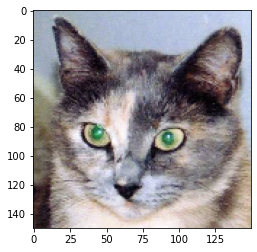

In [29]:
import matplotlib.pyplot as plt

plt.imshow(img_tensor[0])

In [30]:
from keras import models

layer_outputs = [layer.output for layer in model.layers[:8]]
activation_model = models.Model(inputs=model.input, outputs=layer_outputs)

In [31]:
activations = activation_model.predict(img_tensor)

1/1 [==============================] - 0s 115ms/step


In [32]:
first_layer_activation = activations[0]
print(first_layer_activation.shape)

(1, 148, 148, 32)


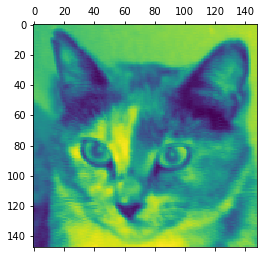

In [34]:
# 20번째 채널 시각화
import matplotlib.pyplot as plt

plt.matshow(first_layer_activation[0, :, :, 19], cmap='viridis')

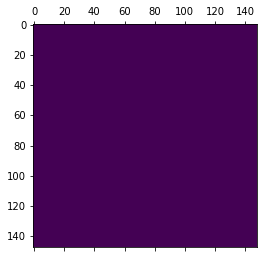

In [35]:
# 16번째 채널 시각화
plt.matshow(first_layer_activation[0, :, :, 15], cmap='viridis')

C:\Users\ytnal\AppData\Local\Temp\ipykernel_12708\2124906745.py:30: RuntimeWarning: invalid value encountered in true_divide
  channel_image /= channel_image.std()


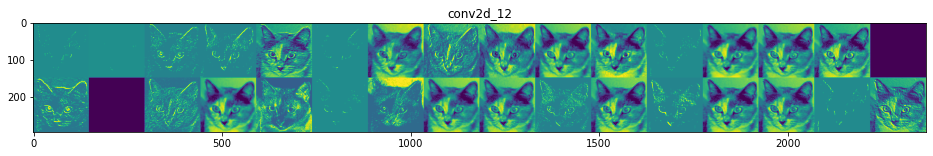

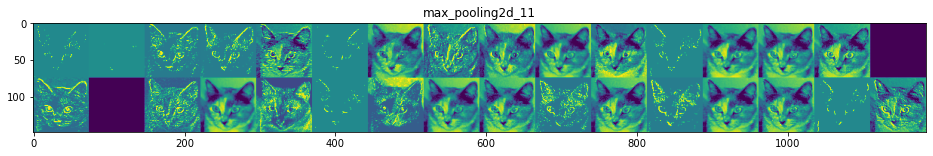

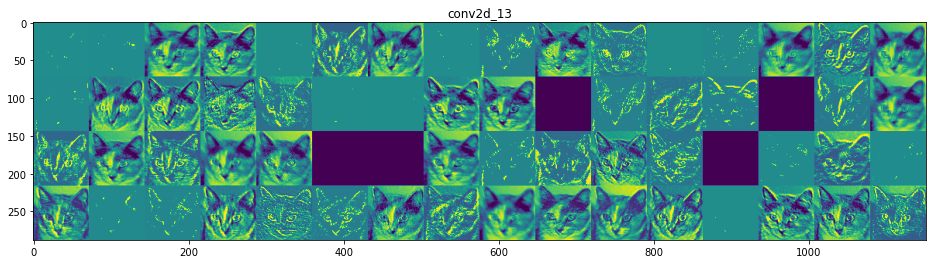

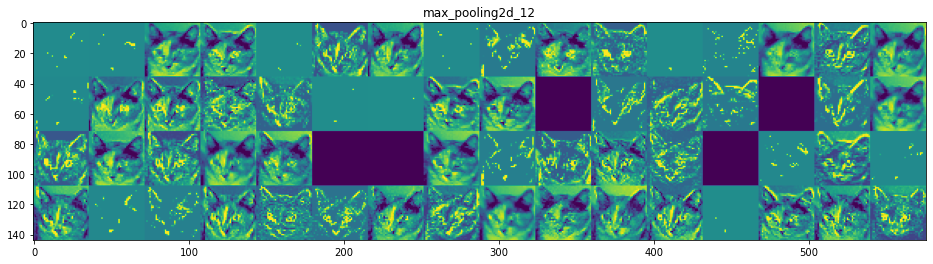

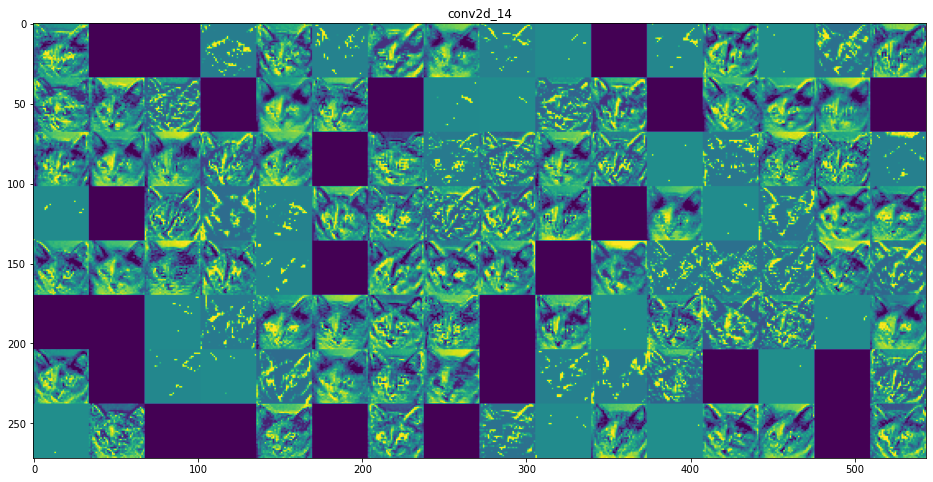

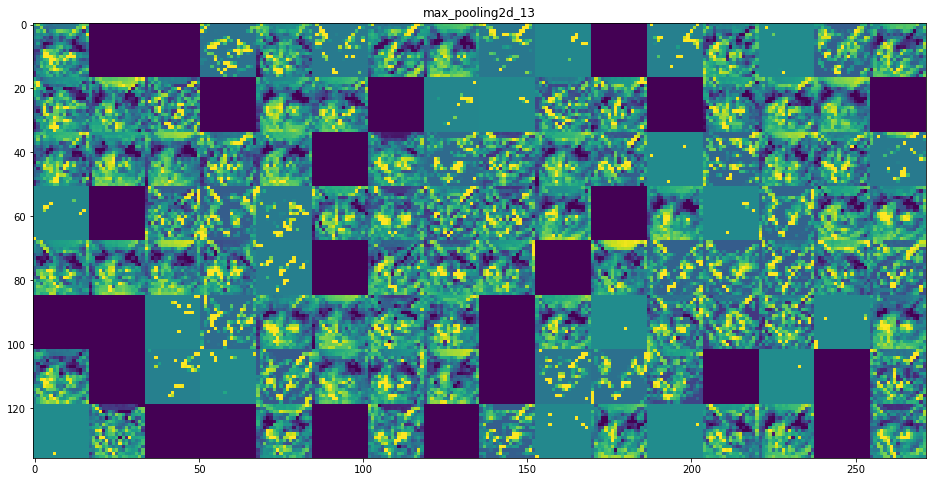

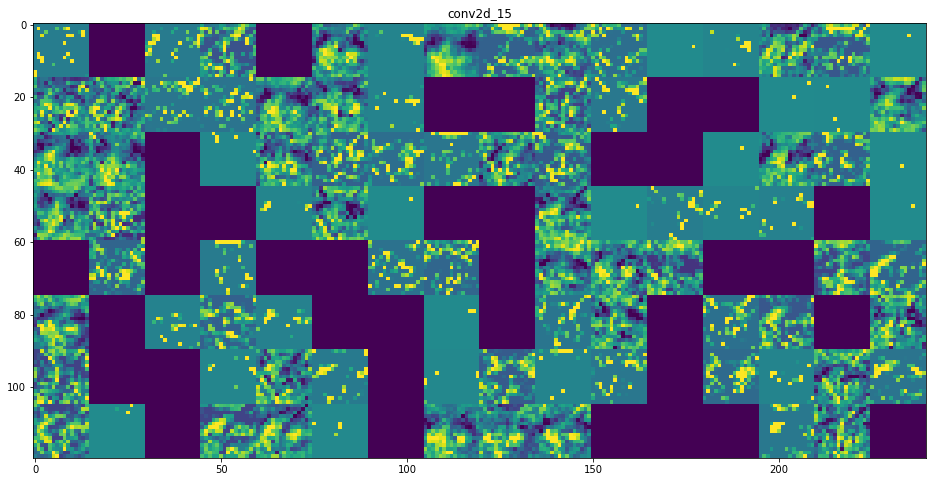

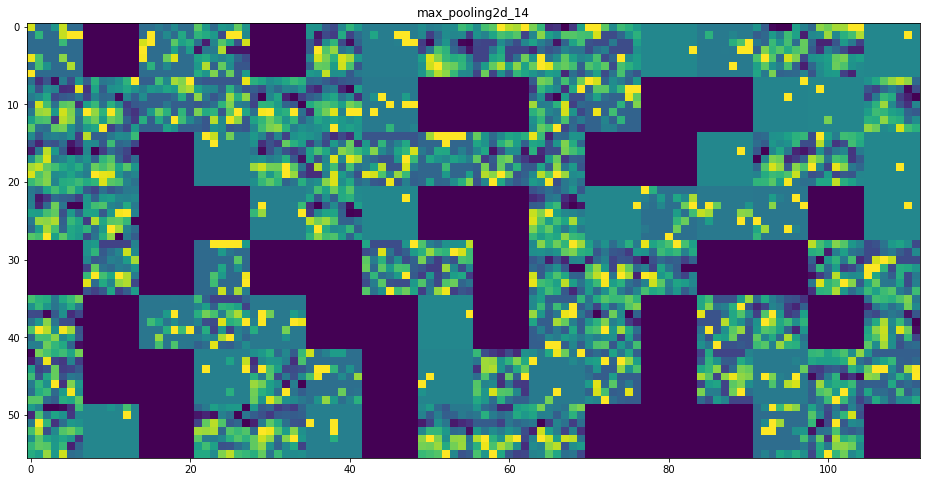

In [36]:
# 중간층의 모든 활성화에 있는 챈러 시각화

# 층의 이름을 그래프 제목으로 사용합니다
layer_names = []
for layer in model.layers[:8]:
    layer_names.append(layer.name)

images_per_row = 16

# 특성 맵을 그립니다
for layer_name, layer_activation in zip(layer_names, activations):
    # 특성 맵에 있는 특성의 수
    n_features = layer_activation.shape[-1]

    # 특성 맵의 크기는 (1, size, size, n_features)입니다
    size = layer_activation.shape[1]

    # 활성화 채널을 위한 그리드 크기를 구합니다
    n_cols = n_features // images_per_row
    display_grid = np.zeros((size * n_cols, images_per_row * size))

    # 각 활성화를 하나의 큰 그리드에 채웁니다
    for col in range(n_cols):
        for row in range(images_per_row):
            channel_image = layer_activation[0,
                                             :, :,
                                             col * images_per_row + row]
            # 그래프로 나타내기 좋게 특성을 처리합니다
            channel_image -= channel_image.mean()
            channel_image /= channel_image.std()
            channel_image *= 64
            channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype('uint8')
            display_grid[col * size : (col + 1) * size,
                         row * size : (row + 1) * size] = channel_image

    # 그리드를 출력합니다
    scale = 1. / size
    plt.figure(figsize=(scale * display_grid.shape[1],
                        scale * display_grid.shape[0]))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')

plt.show()

- 첫번째 층은 여러 종류의 에러 감지기를 모아놓은 것 같음. 이 단계의 활성화에는 초기 사진에 있는 거의 모든 정보가 유지
- 상위층으로 갈수록 활성화는 점점 더 추상적으로 되고 시각적으로 이해하기 어려워짐
- 고양이 귀나 고양이 눈 처럼 고수준 개념을 인코딩하기 시작함
- 비어있는 활성화가 층이 깊어짐에 따라 늘어남

## 5.4.2 컨브넷 필터 시각화하기

In [37]:
from keras.applications import VGG16
from keras import backend as K

model = VGG16(weights='imagenet', include_top=False)

layer_name = 'block3_conv1'
filter_index = 0

layer_output = model.get_layer(layer_name).output
loss = K.mean(layer_output[:, :, :, filter_index])

In [38]:
grads = K.gradients(loss, model.input)[0]

RuntimeError: tf.gradients is not supported when eager execution is enabled. Use tf.GradientTape instead.